In [1]:
import pywt
import scipy.stats
import scipy.signal
import scipy.io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from kpnet.handler import *
from kpnet.network import *
from kpnet.signal import *
from kpnet.callback import *
from kpnet.analysis import *
from kpnet.patterns import *

from wavelets import *

In [166]:
N = 64
time_interval = 50000

In [167]:
np.random.seed(0)
neuron = 5
net = KPNetworkDelayed(N, 3, alpha=0.06, beta=0.2)

callbacks = {}
callbacks['N_' + str(neuron)] = NeuronActivityCallback(time_interval, neuron)

#for i in range(2, 5):
#    callbacks['Trace_' + str(i)] = TraceCallback(time_interval, 189, i)

callbacks['W_5_34'] = Weight0Callback(time_interval, 5, 34)
callbacks['W_2_5'] = Weight0Callback(time_interval, 2, 34)
callbacks['W_34_2'] = Weight0Callback(time_interval, 34, 2)
    
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(N), ZeroSignal(N)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)

CPU times: user 6 s, sys: 0 ns, total: 6 s
Wall time: 6 s


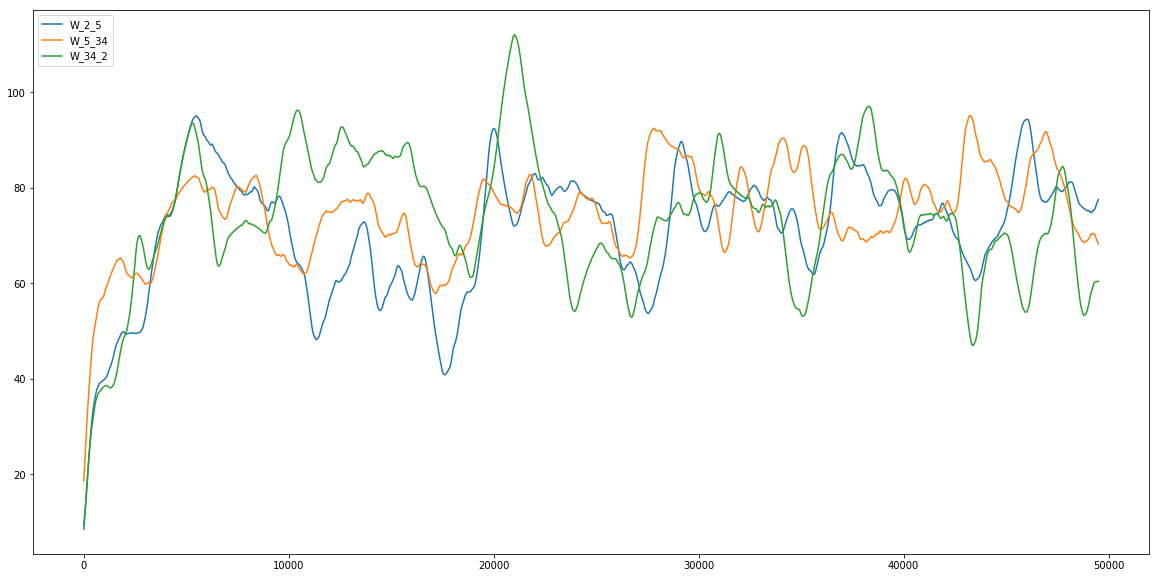

In [207]:
plt.figure(figsize=(20, 10))
for key, value in results.items():
    if key not in ['N_5', 'alpha', 'beta', 'n']:
        plt.plot(moving_average(value), label=key)
        #ent = wentropy_d(value[1500:], 500, 'db2')
plt.legend(loc='upper left')
plt.show()

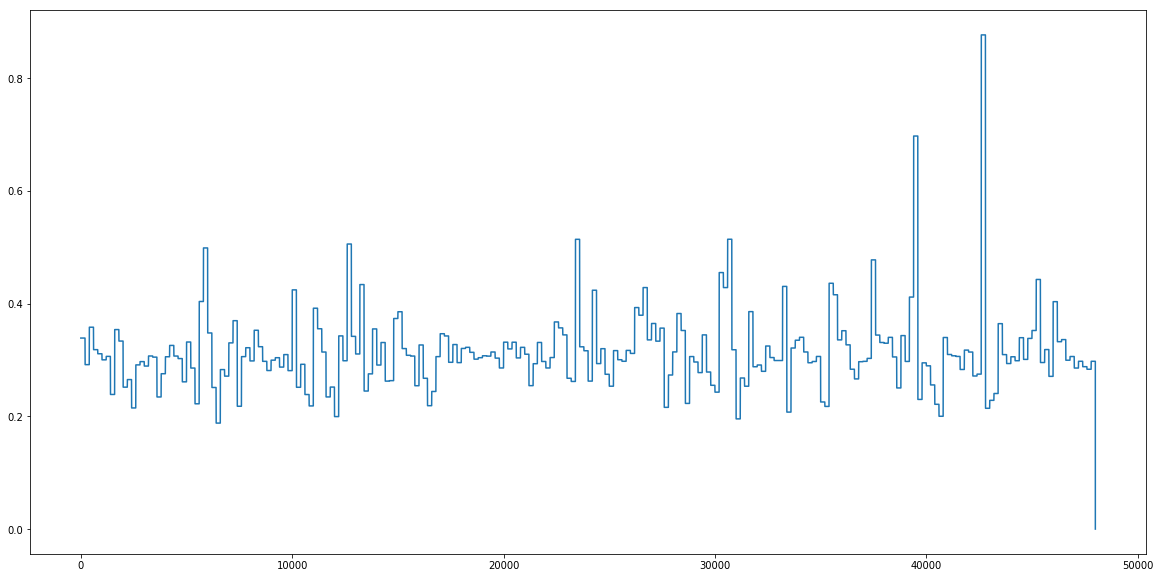

In [218]:
signal = moving_average(results['W_34_2'][1500:])
wname = 'db4'
level = pywt.dwt_max_level(signal.shape[0], pywt.Wavelet(wname))
C = pywt.wavedec(signal, wname, level=level)

d = [np.sum(C[i] ** 2) for i in range(1, level + 1)]
plt.figure(figsize=(20, 10))
plt.plot(wentropy_d(signal, 200, 'db2'))
plt.show()

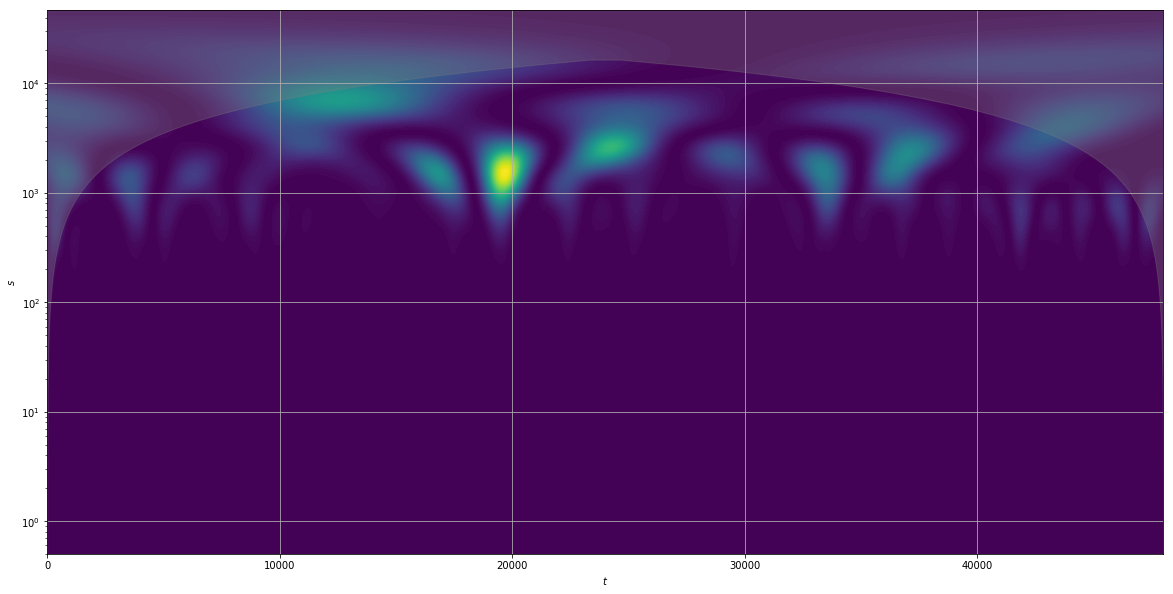

In [211]:
wa = WaveletAnalysis(moving_average(results['W_34_2'][1500:]), wavelet=Ricker())
fig = plt.figure(figsize=(20, 10)) 
ax = plt.subplot()
wa.plot_power(ax)
plt.xlabel(r'$t$')
plt.ylabel(r'$s$')
plt.show()

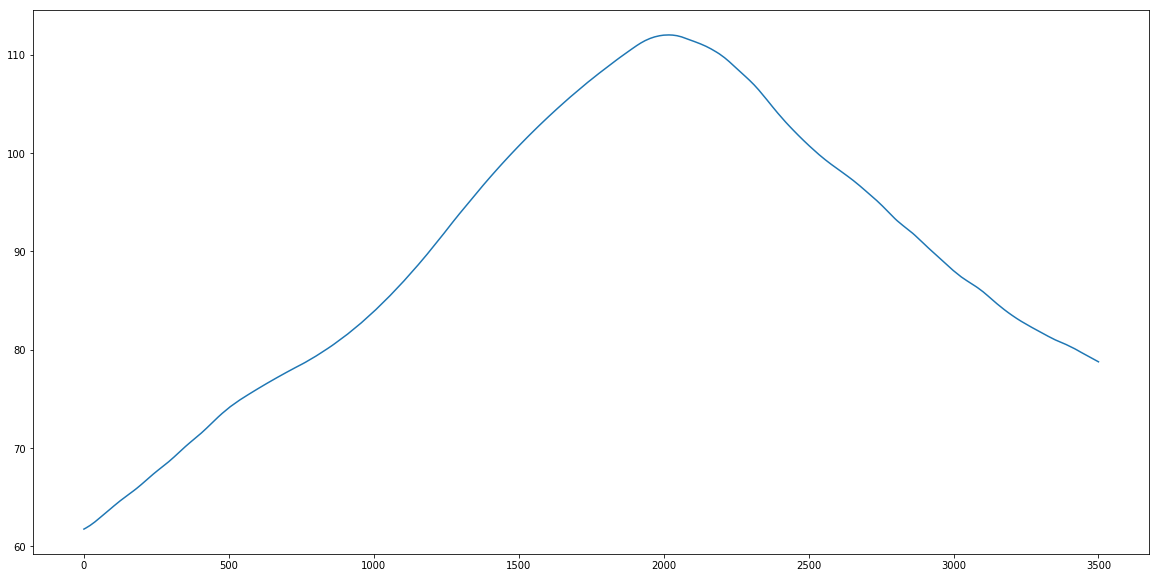

In [200]:
def moving_average(a, n=500) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.figure(figsize=(20, 10))
plt.plot(moving_average(signal))
plt.show()

In [130]:
d

[4934.8070218578432,
 724.56411629270508,
 947.74381546649784,
 161.88659655117885,
 21.956865991130339,
 44.147448169059302,
 74.578923443532801,
 14.859397312993615,
 2.8950552301306764]

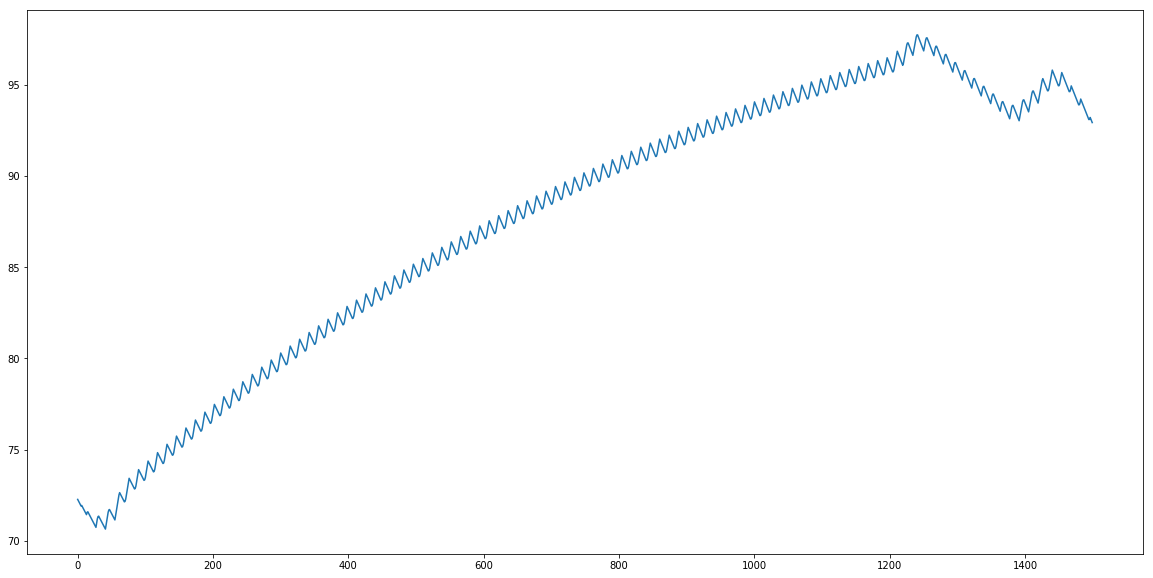

In [132]:
plt.figure(figsize=(20, 10))
plt.plot(results['W_2_5'][4500:6000])
plt.show()

In [77]:
d / np.sum(d)

array([  8.09976907e-01,   1.42715430e-01,   4.00440849e-02,
         5.76118893e-03,   1.25892049e-03,   1.99497424e-04,
         3.93743597e-05,   2.49078339e-06,   1.14394702e-06,
         8.66258562e-07,   8.89965012e-08,   7.09993659e-09])

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(results['W_2'][1500:])
#plt.plot(results['W_34'][1500:])
plt.plot(results['W_37'][1500:])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
div1 = wdivergence_d(results['W_2'][1500:], results['W_37'][1500:], 200, 'db2')
div2 = wdivergence_d(results['W_37'][1500:], results['W_2'][1500:], 200, 'db2')
plt.plot(results['W_2'][1500:] / np.max(results['W_2'][1500:]))
plt.plot(results['W_37'][1500:] / np.max(results['W_37'][1500:]))
plt.plot(div1 / np.max(div1))
plt.plot(div2 / np.max(div2))
plt.show()

In [ ]:
signal = results['W_2'][3000:8000]
level = pywt.dwt_max_level(signal.shape[0], pywt.Wavelet('db2'))
C = pywt.wavedec(signal, 'db2', level=level)
print(level)

In [ ]:
dist = [np.mean(C[i] ** 2) for i in range(1, level + 1)]
dist /= np.sum(dist)
print(scipy.stats.entropy(dist))

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(C[10])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(C[3])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(wentropy_d(results['W_2'][1500:], 2000, 'db2'))
plt.show()

In [ ]:
np.random.seed(0)
neuron = 5
net = KPNetworkDelayed(neurons, 3, alpha=0.06, beta=0.2)

callbacks = {}
callbacks['N_' + str(neuron)] = NeuronActivityCallback(time_interval, neuron)

#for i in range(2, 5):
#    callbacks['Trace_' + str(i)] = TraceCallback(time_interval, 189, i)

for i in range(neurons):
    callbacks['W_' + str(i)] = Weight0Callback(time_interval, i, neuron)
    
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(neurons), ZeroSignal(neurons)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)
plt.figure(figsize=(20, 10))
for i in range(neurons):
    plt.plot(results['W_' + str(i)])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(results['W_2'][1500:])
plt.plot(results['W_34'][1500:])
plt.plot(results['W_37'][1500:])
plt.show()

In [ ]:
np.random.seed(0)
neuron = 5
net = KPNetworkDelayed(neurons, 3, alpha=0.3, beta=1.2)

callbacks = {}
callbacks['N_' + str(neuron)] = NeuronActivityCallback(time_interval, neuron)

#for i in range(2, 5):
#    callbacks['Trace_' + str(i)] = TraceCallback(time_interval, 189, i)

for i in range(neurons):
    callbacks['W_' + str(i)] = Weight0Callback(time_interval, i, neuron)
    
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(neurons), ZeroSignal(neurons)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)
plt.figure(figsize=(20, 10))
for i in range(neurons):
    plt.plot(results['W_' + str(i)])
plt.show()